# Imports and Helper functions

In [1]:
import numpy as np
import librosa
from util import play_audio, load_audio, get_features, get_mfcc, get_lmfe, get_chroma, plot_chroma, plot_mfcc, plot_lmfe
from tqdm.notebook import trange, tqdm
import pandas as pd
import glob
import scipy
from sklearn.metrics import roc_auc_score, recall_score, precision_score, roc_curve
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
%matplotlib inline  

import seaborn as sns

sns.set(style="white", palette="muted")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def convert_complex_to_real(value):
    return complex(value).real

def printmd(string):
    display(Markdown(string))
    
def get_df_feat(df, n_fft, sr, means=False):
    ''' Used to extract Features from spectrograms 
    MFCC, Log mel energy and Chroma (CENS)
    '''
    feat_cols = []

    # Initialize the progress bar
    progress_bar = tqdm(total=len(df), position=0, leave=True)
    for i, row in df.iterrows():
        filename = row['filename']
        feat, labels = get_features(filename, n_fft, sr, frac=10, means=means)

        feat_cols.append(feat)
        lab_cols = labels
        # Update the progress bar
        progress_bar.update(1)

    feat_array = np.vstack(feat_cols)
    lab_array = lab_cols.flatten()

    feat_df = pd.DataFrame(feat_array, columns=list(lab_array), index=df.index)

    # Convert complex numbers to real values
    feat_df = feat_df.applymap(convert_complex_to_real)

    # Assign the columns to the original DataFrame
    df = pd.concat([df, feat_df], axis=1)

    return df

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


def classify_anomalies(train_data, test_data, test_labels, machine, feat_label):
    scaler = MinMaxScaler((-5, 5))
    
    # LOF without PCA
    lof = LocalOutlierFactor(novelty=True, contamination=0.0001)
    lof_pipe = Pipeline([("scaler", scaler), ("classifier", lof)])
    
    # LOF with PCA
    pca_lof = PCA(0.9)
    lof_pca_pipe = Pipeline([("scaler", scaler), ("pca", pca_lof), ("classifier", lof)])
    
    # Isolation Forest without PCA
    isolation_forest = IsolationForest(contamination=0.0001)
    isolation_forest_pipe = Pipeline([("scaler", scaler), ("classifier", isolation_forest)])
    
    # Isolation Forest with PCA
    pca_if = PCA(0.9)
    isolation_forest_pca_pipe = Pipeline([("scaler", scaler), ("pca", pca_if), ("classifier", isolation_forest)])

    models = {
        "LOF": lof_pipe,
        "LOF + PCA": lof_pca_pipe,
        "Isolation Forest": isolation_forest_pipe,
        "Isolation Forest + PCA": isolation_forest_pca_pipe,
    }

    results = {
        "Machine": machine,
        "Features": feat_label,
        "Model": [],
        "AUC": [],
        "Recall": [],
        "Precision": [],
        "Abnormal (-1) F1": [],
    }
    fig, axes = plt.subplots(ncols=len(models), nrows=1, figsize=(16, 4))

    for i, (model_name, model) in enumerate(models.items()):
        roc_ax = axes[i]
        model.fit(train_data)
        scores = model.decision_function(test_data)
        auc = roc_auc_score(test_labels, scores)  # Use -scores because higher score should be less anomalous
        fpr, tpr, thresholds = roc_curve(test_labels, scores)
        # Plot the ROC curve
        roc_ax.plot(fpr, tpr)
        roc_ax.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.7)  # Diagonal line for reference
        roc_ax.set_title(f'{model_name}\n ROC Curve\n AUC = {auc:.2f}')
        roc_ax.set_xlabel('False Positive Rate')
        roc_ax.set_ylabel('True Positive Rate')
        roc_ax.legend(['ROC curve', 'Random'], fontsize="9", loc='lower right')

        # Sort scores in ascending order and find the threshold for 85% correctly classified normal data
        sorted_scores = np.sort(thresholds)
        threshold_index = int(0.85 * len(sorted_scores))
        threshold = sorted_scores[threshold_index]

        # Make predictions based on the threshold
        predictions = np.where(scores >= threshold, 1, -1)
        recall = recall_score(test_labels, predictions, average='weighted')
        precision = precision_score(test_labels, predictions, average='weighted')
        abf1 = metrics.f1_score(test_labels, predictions, pos_label= -1, average='binary')

        results["Model"].append(model_name)
        results["AUC"].append(auc)
        results["Recall"].append(recall)
        results["Precision"].append(precision)
        results["Abnormal (-1) F1"].append(abf1)

    results_df = pd.DataFrame(results)
    print(f"{feat_label} features were reduced to {pca_lof.n_components_} components for LOF")
    print(f"{feat_label} features were reduced to {pca_if.n_components_} components for Isolation Forest")
    return results_df




# Get features (no mean)

In [5]:
df = pd.read_pickle('working/df.pkl')

In [6]:
df['type'] = df['filename'].apply(lambda x: x.split('/')[1])

In [7]:
df.columns

Index(['filename', 'label', 'type', 'model'], dtype='object')

In [8]:
# df_fan = df[df['type'] == 'fan'].copy()
# df_valve = df[df['type'] == 'valve'].copy()

In [9]:
# df_fan.shape

In [10]:
# df_fan = get_df_feat(df_fan, n_fft=2048, sr=16000)

In [11]:
# df_valve = get_df_feat(df_valve, n_fft=2048, sr=16000)

In [12]:
# df_valve.to_pickle('working/df_valve.pkl') # 처음 한 번만
# df_fan.to_pickle('working/df_fan.pkl') # 처음 한 번만

df_valve =  pd.read_pickle('working/df_valve.pkl')
df_fan =  pd.read_pickle('working/df_fan.pkl')

In [13]:
df_fan.columns = df_fan.columns.str.replace('_', ' ').astype('str')
df_valve.columns = df_valve.columns.str.replace('_', ' ').astype('str')

In [14]:
valcols = df_valve.columns[8:]
valcols

Index(['lmfe2 5', 'lmfe2 6', 'lmfe2 7', 'lmfe2 8', 'lmfe2 9', 'lmfe2 10',
       'lmfe2 11', 'lmfe2 12', 'lmfe3 1', 'lmfe3 2',
       ...
       'chroma12 54', 'chroma12 55', 'chroma12 56', 'chroma12 57',
       'chroma12 58', 'chroma12 59', 'chroma12 60', 'chroma12 61',
       'chroma12 62', 'chroma12 63'],
      dtype='object', length=3128)

In [15]:
chroma_only = [col for col in valcols if col.startswith('chroma')]
mel_only = [col for col in valcols if col.startswith('mf') or col.startswith('lm')]

In [16]:
chroma_only

['chroma1 1',
 'chroma1 2',
 'chroma1 3',
 'chroma1 4',
 'chroma1 5',
 'chroma1 6',
 'chroma1 7',
 'chroma1 8',
 'chroma1 9',
 'chroma1 10',
 'chroma1 11',
 'chroma1 12',
 'chroma1 13',
 'chroma1 14',
 'chroma1 15',
 'chroma1 16',
 'chroma1 17',
 'chroma1 18',
 'chroma1 19',
 'chroma1 20',
 'chroma1 21',
 'chroma1 22',
 'chroma1 23',
 'chroma1 24',
 'chroma1 25',
 'chroma1 26',
 'chroma1 27',
 'chroma1 28',
 'chroma1 29',
 'chroma1 30',
 'chroma1 31',
 'chroma1 32',
 'chroma1 33',
 'chroma1 34',
 'chroma1 35',
 'chroma1 36',
 'chroma1 37',
 'chroma1 38',
 'chroma1 39',
 'chroma1 40',
 'chroma1 41',
 'chroma1 42',
 'chroma1 43',
 'chroma1 44',
 'chroma1 45',
 'chroma1 46',
 'chroma1 47',
 'chroma1 48',
 'chroma1 49',
 'chroma1 50',
 'chroma1 51',
 'chroma1 52',
 'chroma1 53',
 'chroma1 54',
 'chroma1 55',
 'chroma1 56',
 'chroma1 57',
 'chroma1 58',
 'chroma1 59',
 'chroma1 60',
 'chroma1 61',
 'chroma1 62',
 'chroma1 63',
 'chroma2 1',
 'chroma2 2',
 'chroma2 3',
 'chroma2 4',
 'chroma

In [17]:
fancols = df_fan.columns[8:]
fancols

Index(['lmfe2 5', 'lmfe2 6', 'lmfe2 7', 'lmfe2 8', 'lmfe2 9', 'lmfe2 10',
       'lmfe2 11', 'lmfe2 12', 'lmfe3 1', 'lmfe3 2',
       ...
       'chroma12 54', 'chroma12 55', 'chroma12 56', 'chroma12 57',
       'chroma12 58', 'chroma12 59', 'chroma12 60', 'chroma12 61',
       'chroma12 62', 'chroma12 63'],
      dtype='object', length=3128)

In [18]:
'label' in df_valve.columns

True

In [19]:
norm = df_valve[(df_valve["label"] == 1)].sample(frac = 0.8, random_state = 66)

In [20]:
df_valve['train'] = 0
df_valve['test'] = 0
df_valve.loc[norm.index, 'train'] = 1
df_valve.loc[df_valve.index, 'test'] = 1

## Valve

In [21]:
train_data = df_valve[df_valve['train'] == 1]
test_data = df_valve[df_valve['test'] == 1]
y_val = df_valve[(df_valve["test"] == 1)]['label'].tolist()

mel features were reduced to 485 components for LOF
mel features were reduced to 485 components for Isolation Forest
|    | Machine   | Features   | Model                  |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
|---:|:----------|:-----------|:-----------------------|---------:|---------:|------------:|-------------------:|
|  0 | valve     | mel        | LOF                    | 0.496179 | 0.189339 |    0.736376 |           0.193296 |
|  1 | valve     | mel        | LOF + PCA              | 0.357718 | 0.149117 |    0.642067 |           0.184326 |
|  2 | valve     | mel        | Isolation Forest       | 0.489553 | 0.24068  |    0.799705 |           0.208589 |
|  3 | valve     | mel        | Isolation Forest + PCA | 0.234378 | 0.129496 |    0.545327 |           0.178395 |


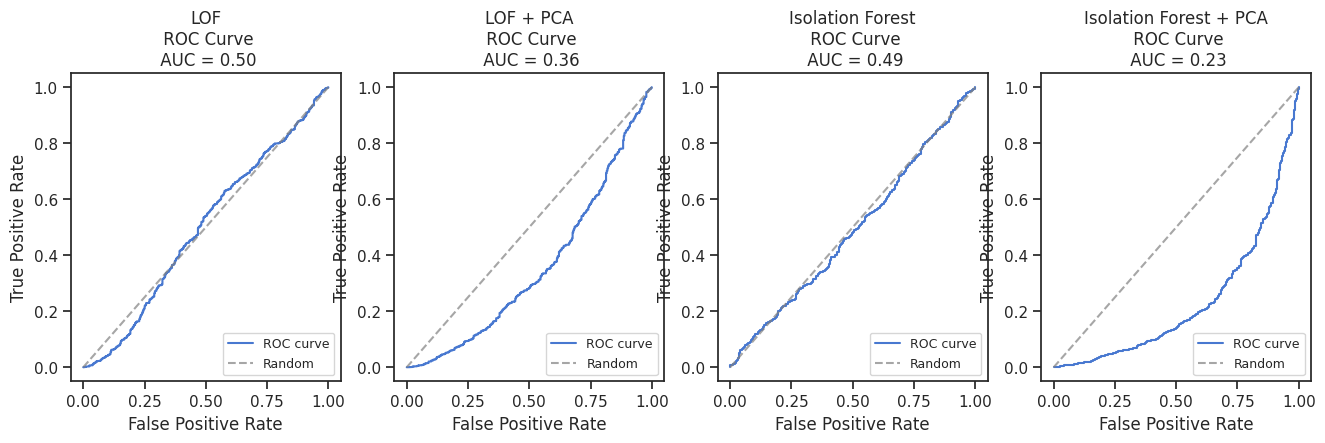

In [22]:
valve_mel = classify_anomalies(train_data[mel_only], test_data[mel_only], y_val, 'valve', 'mel')
print(valve_mel.to_markdown())

chroma features were reduced to 70 components for LOF
chroma features were reduced to 70 components for Isolation Forest
|    | Machine   | Features   | Model                  |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
|---:|:----------|:-----------|:-----------------------|---------:|---------:|------------:|-------------------:|
|  0 | valve     | chroma     | LOF                    | 0.515346 | 0.223022 |    0.795328 |           0.207472 |
|  1 | valve     | chroma     | LOF + PCA              | 0.501168 | 0.219097 |    0.792285 |           0.206645 |
|  2 | valve     | chroma     | Isolation Forest       | 0.466786 | 0.206344 |    0.779257 |           0.203479 |
|  3 | valve     | chroma     | Isolation Forest + PCA | 0.46949  | 0.210922 |    0.775078 |           0.201786 |


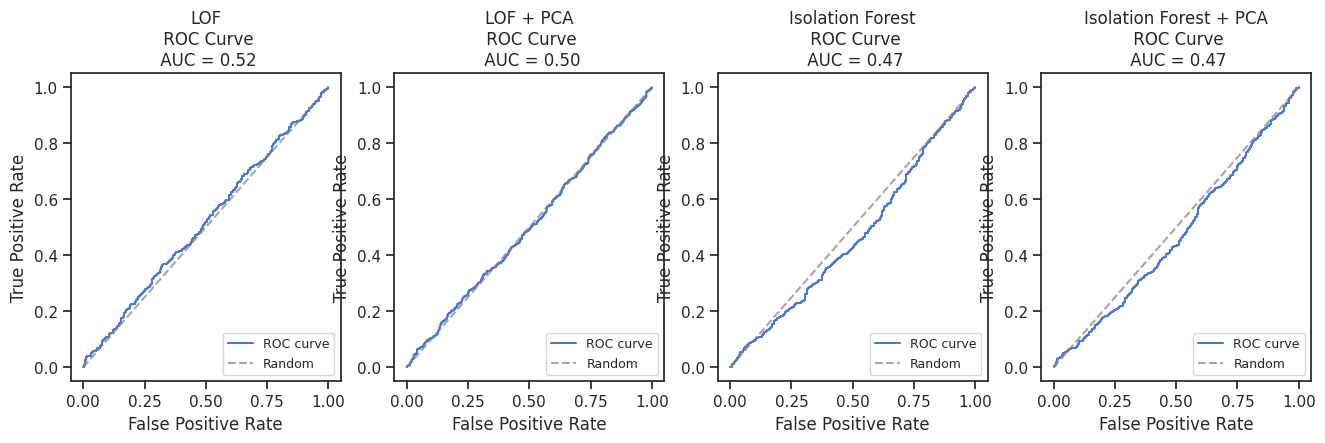

In [23]:
valve_chroma = classify_anomalies(train_data[chroma_only], test_data[chroma_only], y_val, 'valve', 'chroma')
print(valve_chroma.to_markdown())

All features were reduced to 487 components for LOF
All features were reduced to 487 components for Isolation Forest
|    | Machine   | Features   | Model                  |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
|---:|:----------|:-----------|:-----------------------|---------:|---------:|------------:|-------------------:|
|  0 | valve     | All        | LOF                    | 0.500197 | 0.207325 |    0.77496  |           0.202107 |
|  1 | valve     | All        | LOF + PCA              | 0.378937 | 0.146501 |    0.623287 |           0.180791 |
|  2 | valve     | All        | Isolation Forest       | 0.479123 | 0.208633 |    0.772855 |           0.20132  |
|  3 | valve     | All        | Isolation Forest + PCA | 0.257432 | 0.122629 |    0.497058 |           0.176236 |


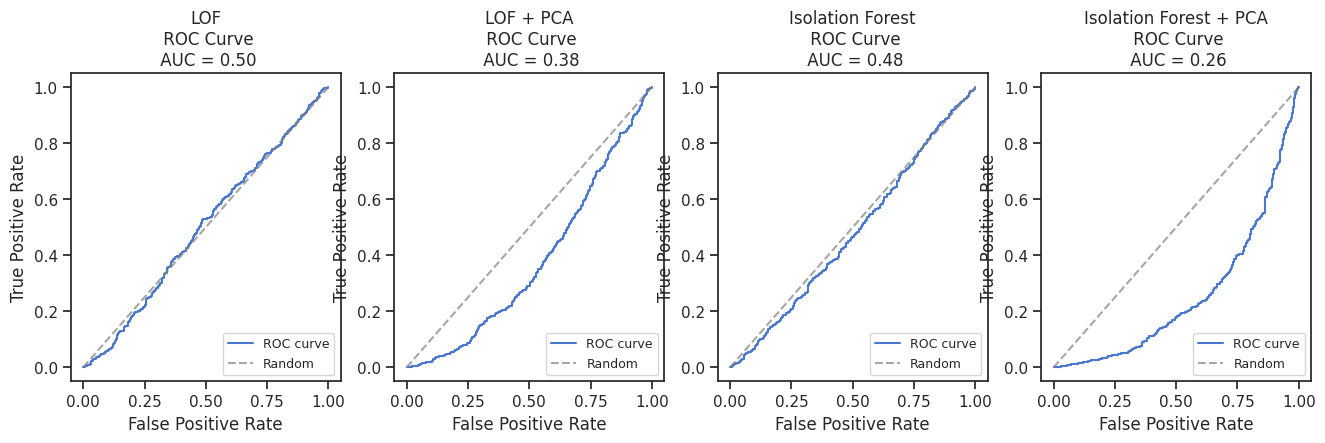

In [24]:
valve_allF = classify_anomalies(train_data[valcols], test_data[valcols], y_val, 'valve', 'All')
print(valve_allF.to_markdown())

## Fan

In [25]:
norm = df_fan[(df_fan["label"] == 1)].sample(frac = 0.8, random_state = 66)
df_fan['train'] = 0
df_fan['test'] = 0
df_fan.loc[norm.index, 'train'] = 1
df_fan.loc[df_fan.index, 'test'] = 1

In [26]:
train_data = df_fan[df_fan['train'] == 1]
test_data = df_fan[df_fan['test'] == 1]
y_val = df_fan[(df_fan["test"] == 1)]['label'].tolist()

mel features were reduced to 534 components for LOF
mel features were reduced to 534 components for Isolation Forest
+----+-----------+------------+------------------------+----------+----------+-------------+--------------------+
|    | Machine   | Features   | Model                  |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
+====+===========+============+========================+==========+==========+=============+====================+
|  0 | fan       | mel        | LOF                    | 0.679721 | 0.47724  |    0.741231 |           0.476739 |
+----+-----------+------------+------------------------+----------+----------+-------------+--------------------+
|  1 | fan       | mel        | LOF + PCA              | 0.506229 | 0.337805 |    0.604442 |           0.404053 |
+----+-----------+------------+------------------------+----------+----------+-------------+--------------------+
|  2 | fan       | mel        | Isolation Forest       | 0.547123 | 0.369669 |    0.6

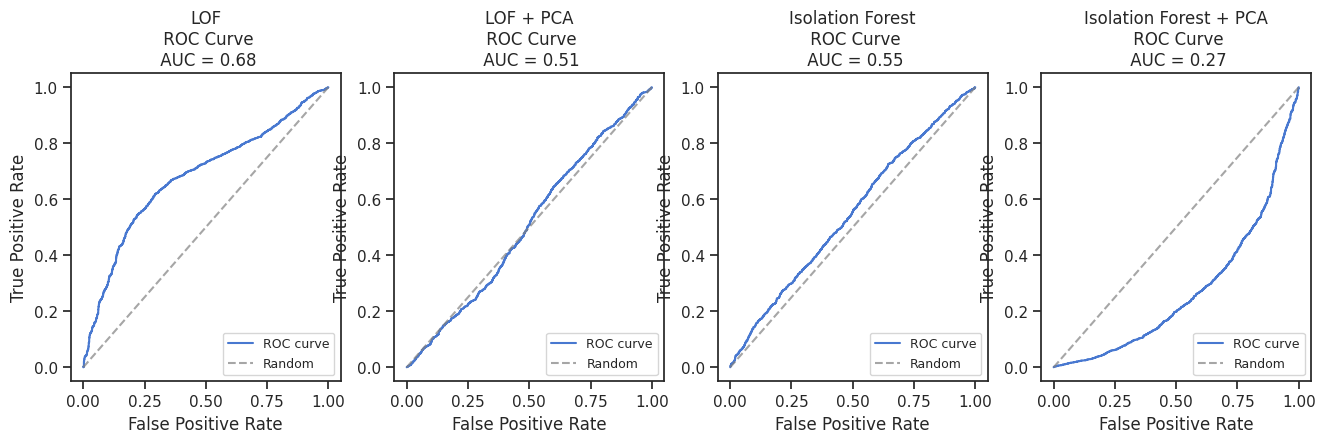

In [27]:
fan_mel = classify_anomalies(train_data[mel_only], test_data[mel_only], y_val, 'fan', 'mel')
print(fan_mel.to_markdown(tablefmt="grid"))

chroma features were reduced to 68 components for LOF
chroma features were reduced to 68 components for Isolation Forest
+----+-----------+------------+------------------------+----------+----------+-------------+--------------------+
|    | Machine   | Features   | Model                  |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
+====+===========+============+========================+==========+==========+=============+====================+
|  0 | fan       | chroma     | LOF                    | 0.640302 | 0.40896  |    0.696115 |           0.441981 |
+----+-----------+------------+------------------------+----------+----------+-------------+--------------------+
|  1 | fan       | chroma     | LOF + PCA              | 0.643995 | 0.416627 |    0.704039 |           0.446465 |
+----+-----------+------------+------------------------+----------+----------+-------------+--------------------+
|  2 | fan       | chroma     | Isolation Forest       | 0.566947 | 0.370867 |   

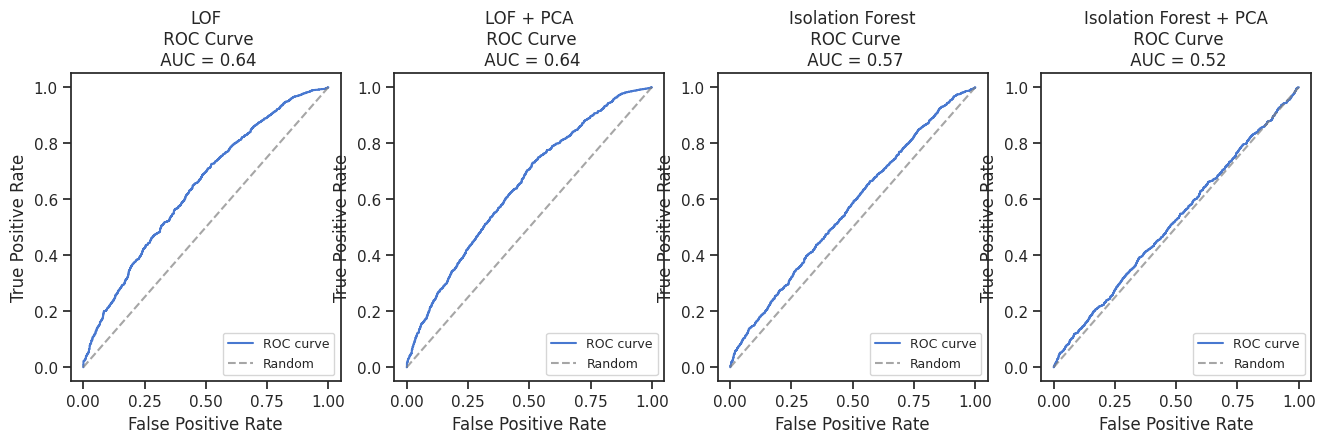

In [28]:
fan_chroma = classify_anomalies(train_data[chroma_only], test_data[chroma_only], y_val, 'fan', 'chroma')
print(fan_chroma.to_markdown(tablefmt="grid"))

All features were reduced to 533 components for LOF
All features were reduced to 533 components for Isolation Forest
+----+-----------+------------+------------------------+----------+----------+-------------+--------------------+
|    | Machine   | Features   | Model                  |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
+====+===========+============+========================+==========+==========+=============+====================+
|  0 | fan       | All        | LOF                    | 0.703695 | 0.493771 |    0.748859 |           0.485262 |
+----+-----------+------------+------------------------+----------+----------+-------------+--------------------+
|  1 | fan       | All        | LOF + PCA              | 0.58157  | 0.384284 |    0.674279 |           0.430408 |
+----+-----------+------------+------------------------+----------+----------+-------------+--------------------+
|  2 | fan       | All        | Isolation Forest       | 0.578623 | 0.393148 |    0.6

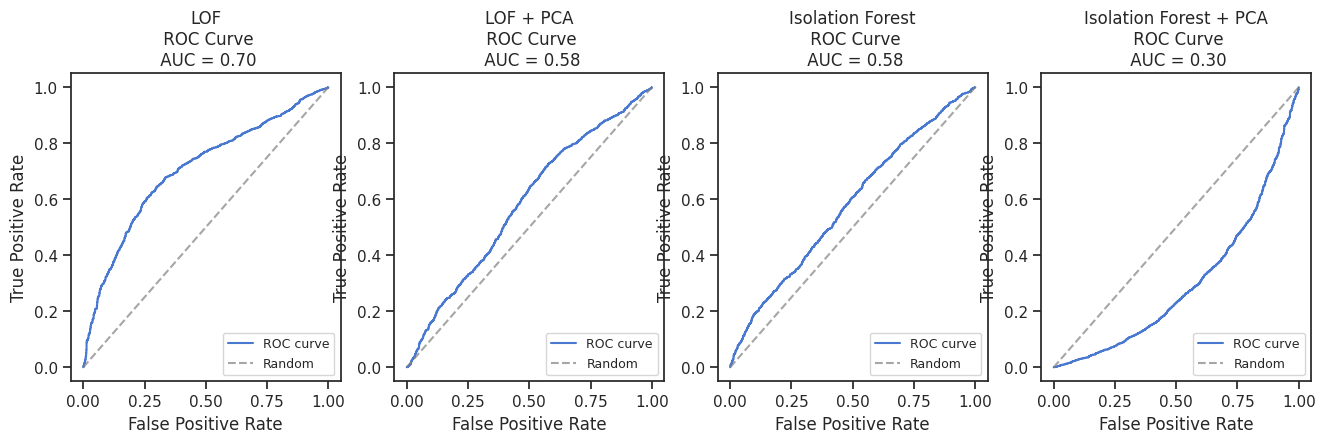

In [29]:
fan_allF = classify_anomalies(train_data[fancols], test_data[fancols], y_val, 'fan', 'All')
print(fan_allF.to_markdown(tablefmt="grid"))

# Get features (means over time axis)
### i.e. the mean for each chroma, mfcc and log mel energy filterbank 

In [30]:
df = pd.read_pickle('working/df.pkl')

In [31]:
df['type'] = df['filename'].apply(lambda x: x.split('/')[1])

In [32]:
df.columns

Index(['filename', 'label', 'type', 'model'], dtype='object')

In [33]:
# df_fan = df[df['type'] == 'fan'].copy()
# df_valve = df[df['type'] == 'valve'].copy()

In [34]:
# df_fan = get_df_feat(df_fan, n_fft=2048, sr=16000, means=True)

In [35]:
# df_valve = get_df_feat(df_valve, n_fft=2048, sr=16000, means=True)

In [36]:
# df_valve.to_pickle('working/df_valve_means.pkl')
# df_fan.to_pickle('working/df_fan_means.pkl')

In [37]:
df_valve =  pd.read_pickle('working/df_valve_means.pkl')
df_fan =  pd.read_pickle('working/df_fan_means.pkl')

In [38]:
# valcols = df_valve.drop('recording', axis=1).columns[8:]
valcols

Index(['lmfe2 5', 'lmfe2 6', 'lmfe2 7', 'lmfe2 8', 'lmfe2 9', 'lmfe2 10',
       'lmfe2 11', 'lmfe2 12', 'lmfe3 1', 'lmfe3 2',
       ...
       'chroma12 54', 'chroma12 55', 'chroma12 56', 'chroma12 57',
       'chroma12 58', 'chroma12 59', 'chroma12 60', 'chroma12 61',
       'chroma12 62', 'chroma12 63'],
      dtype='object', length=3128)

In [39]:
# chroma_only = [col for col in valcols if col.startswith('chroma')]
chroma_only = [col for col in df if col.startswith('chroma')]
# mel_only = [col for col in valcols if col.startswith('mf') or col.startswith('lm')]
mel_only = [col for col in df if col.startswith('mf') or col.startswith('lm')]

In [40]:
chroma_only

[]

In [41]:
# fancols = df_fan.drop('recording', axis=1).columns[8:]
fancols

Index(['lmfe2 5', 'lmfe2 6', 'lmfe2 7', 'lmfe2 8', 'lmfe2 9', 'lmfe2 10',
       'lmfe2 11', 'lmfe2 12', 'lmfe3 1', 'lmfe3 2',
       ...
       'chroma12 54', 'chroma12 55', 'chroma12 56', 'chroma12 57',
       'chroma12 58', 'chroma12 59', 'chroma12 60', 'chroma12 61',
       'chroma12 62', 'chroma12 63'],
      dtype='object', length=3128)

In [42]:
df_fan['recording'] = df_fan['label'].replace({-1 : 'abnormal', 1 : 'normal'})
df_valve['recording'] = df_valve['label'].replace({-1 : 'abnormal', 1 : 'normal'})

***
#### Plot chroma means

In [43]:
mapping_dict = {f'chroma{i}': pitch for i, pitch in enumerate(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'], 1)}
df = pd.concat([df_fan, df_valve], ignore_index=True) 

In [44]:
df.shape
df.columns

Index(['filename', 'label', 'type', 'model', 'lmfe1', 'lmfe2', 'lmfe3',
       'lmfe4', 'lmfe5', 'lmfe6', 'lmfe7', 'lmfe8', 'lmfe9', 'lmfe10',
       'lmfe11', 'lmfe12', 'lmfe13', 'lmfe14', 'lmfe15', 'lmfe16', 'lmfe17',
       'lmfe18', 'lmfe19', 'lmfe20', 'lmfe21', 'lmfe22', 'lmfe23', 'lmfe24',
       'lmfe25', 'lmfe26', 'lmfe27', 'lmfe28', 'lmfe29', 'lmfe30', 'lmfe31',
       'lmfe32', 'lmfe33', 'lmfe34', 'lmfe35', 'lmfe36', 'lmfe37', 'lmfe38',
       'lmfe39', 'lmfe40', 'lmfe41', 'lmfe42', 'lmfe43', 'lmfe44', 'lmfe45',
       'lmfe46', 'lmfe47', 'lmfe48', 'lmfe49', 'lmfe50', 'lmfe51', 'lmfe52',
       'lmfe53', 'lmfe54', 'lmfe55', 'lmfe56', 'lmfe57', 'lmfe58', 'lmfe59',
       'lmfe60', 'lmfe61', 'lmfe62', 'lmfe63', 'lmfe64', 'mfcc1', 'mfcc2',
       'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10',
       'mfcc11', 'mfcc12', 'chroma1', 'chroma2', 'chroma3', 'chroma4',
       'chroma5', 'chroma6', 'chroma7', 'chroma8', 'chroma9', 'chroma10',
       'chroma11',

In [45]:
# chroma_only = [col for col in valcols if col.startswith('chroma')]
chroma_only = [col for col in df if col.startswith('chroma')]
chroma_only

['chroma1',
 'chroma2',
 'chroma3',
 'chroma4',
 'chroma5',
 'chroma6',
 'chroma7',
 'chroma8',
 'chroma9',
 'chroma10',
 'chroma11',
 'chroma12']

In [46]:
df_chroma = pd.melt(df_valve, id_vars=['filename', 'label', 'type', 'model', 'recording'], value_vars=chroma_only, var_name='chroma', value_name='cens')

In [47]:
df_chroma.shape

(36696, 7)

In [48]:
df_chroma['notes'] = df_chroma['chroma'].replace(mapping_dict)

In [49]:
df_chroma.shape

(36696, 8)

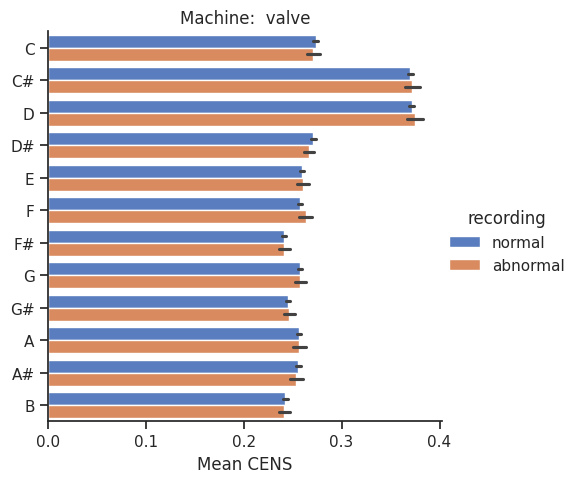

In [50]:
g = sns.catplot(data=df_chroma, x="cens", y="notes", hue="recording", kind="bar", col='type')
g.set_axis_labels("Mean CENS", "")

g.set_titles("Machine:  {col_name}")
g.savefig("figs/mean_cens.eps", transparent=True, dpi=400)

plt.show()

In [51]:
# chroma_only = [col for col in valcols if col.startswith('chroma')]
chroma_only = [col for col in df if col.startswith('chroma')]

## Valve

In [52]:
df_valve =  pd.read_pickle('working/df_valve_means.pkl')
df_fan =  pd.read_pickle('working/df_fan_means.pkl')

In [53]:
norm = df_valve[(df_valve["label"] == 1)].sample(frac = 0.8, random_state = 66)
df_valve['train'] = 0
df_valve['test'] = 0
df_valve.loc[norm.index, 'train'] = 1
df_valve.loc[df_valve.index, 'test'] = 1

In [54]:
train_data = df_valve[df_valve['train'] == 1]
test_data = df_valve[df_valve['test'] == 1]
y_val = df_valve[(df_valve["test"] == 1)]['label'].tolist()

In [55]:
valcols = df_valve.columns[8:]
chroma_only = [col for col in valcols if col.startswith('chroma')]
mel_only = [col for col in valcols if col.startswith('mf') or col.startswith('lm')]

mel-means features were reduced to 14 components for LOF
mel-means features were reduced to 14 components for Isolation Forest
|    | Machine   | Features   | Model                  |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
|---:|:----------|:-----------|:-----------------------|---------:|---------:|------------:|-------------------:|
|  0 | valve     | mel-means  | LOF                    | 0.521615 | 0.19915  |    0.771758 |           0.20202  |
|  1 | valve     | mel-means  | LOF + PCA              | 0.509634 | 0.212884 |    0.773665 |           0.201128 |
|  2 | valve     | mel-means  | Isolation Forest       | 0.502342 | 0.212884 |    0.783633 |           0.204298 |
|  3 | valve     | mel-means  | Isolation Forest + PCA | 0.496053 | 0.241988 |    0.803451 |           0.209952 |


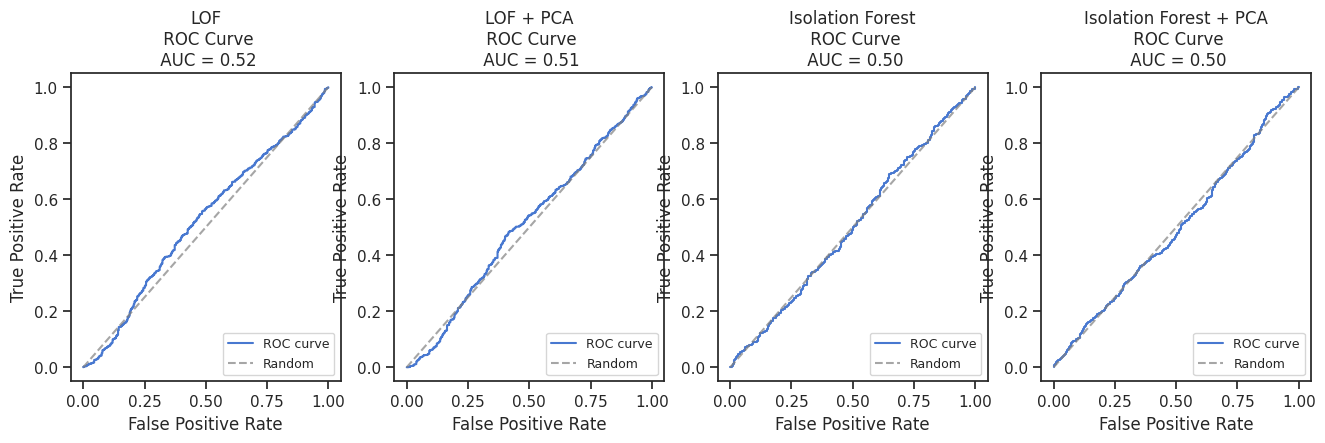

In [56]:
valve_mel_means = classify_anomalies(train_data[mel_only], test_data[mel_only], y_val, 'valve', 'mel-means')
print(valve_mel_means.to_markdown())

chroma-means features were reduced to 9 components for LOF
chroma-means features were reduced to 9 components for Isolation Forest
|    | Machine   | Features     | Model                  |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
|---:|:----------|:-------------|:-----------------------|---------:|---------:|------------:|-------------------:|
|  0 | valve     | chroma-means | LOF                    | 0.509474 | 0.242315 |    0.805129 |           0.210562 |
|  1 | valve     | chroma-means | LOF + PCA              | 0.509339 | 0.240353 |    0.796596 |           0.207438 |
|  2 | valve     | chroma-means | Isolation Forest       | 0.470709 | 0.221387 |    0.784328 |           0.203945 |
|  3 | valve     | chroma-means | Isolation Forest + PCA | 0.475604 | 0.231197 |    0.791845 |           0.206011 |


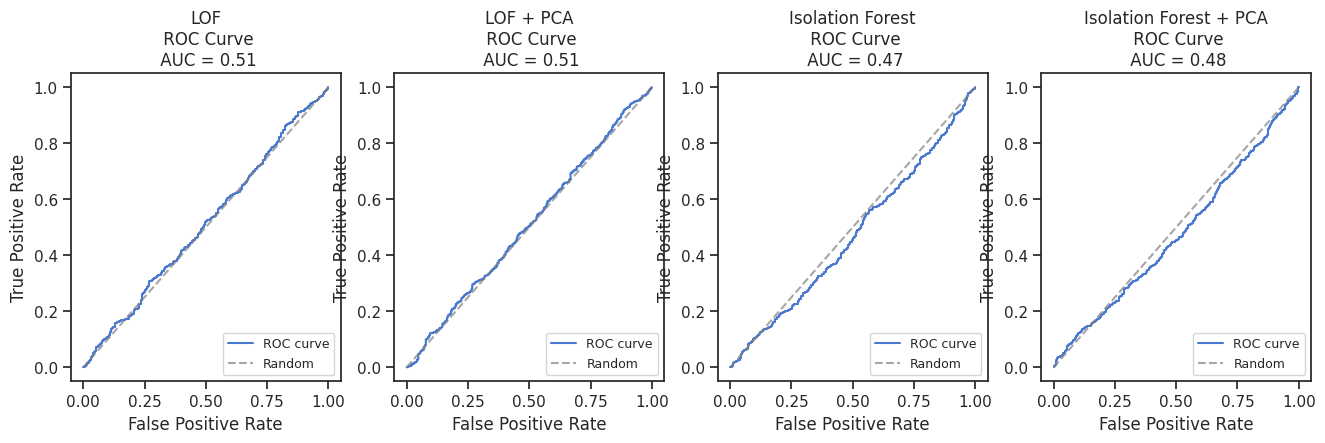

In [57]:
valve_chroma_means = classify_anomalies(train_data[chroma_only], test_data[chroma_only], y_val, 'valve', 'chroma-means')
print(valve_chroma_means.to_markdown())

In [58]:
# valcols = df_valve.drop('recording', axis=1).columns[8:]
valcols = df_valve.columns[8:]

# 데이터 전처리 (문자열 값 필터링)
train_data = train_data[train_data[valcols] != 'normal']
test_data = test_data[test_data[valcols] != 'normal']

All-means features were reduced to 19 components for LOF
All-means features were reduced to 19 components for Isolation Forest
|    | Machine   | Features   | Model                  |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
|---:|:----------|:-----------|:-----------------------|---------:|---------:|------------:|-------------------:|
|  0 | valve     | All-means  | LOF                    | 0.893442 | 0.799215 |    0.912999 |           0.518053 |
|  1 | valve     | All-means  | LOF + PCA              | 0.51625  | 0.233159 |    0.797787 |           0.208038 |
|  2 | valve     | All-means  | Isolation Forest       | 0.49991  | 0.224984 |    0.791929 |           0.206296 |
|  3 | valve     | All-means  | Isolation Forest + PCA | 0.472999 | 0.241661 |    0.803252 |           0.209881 |


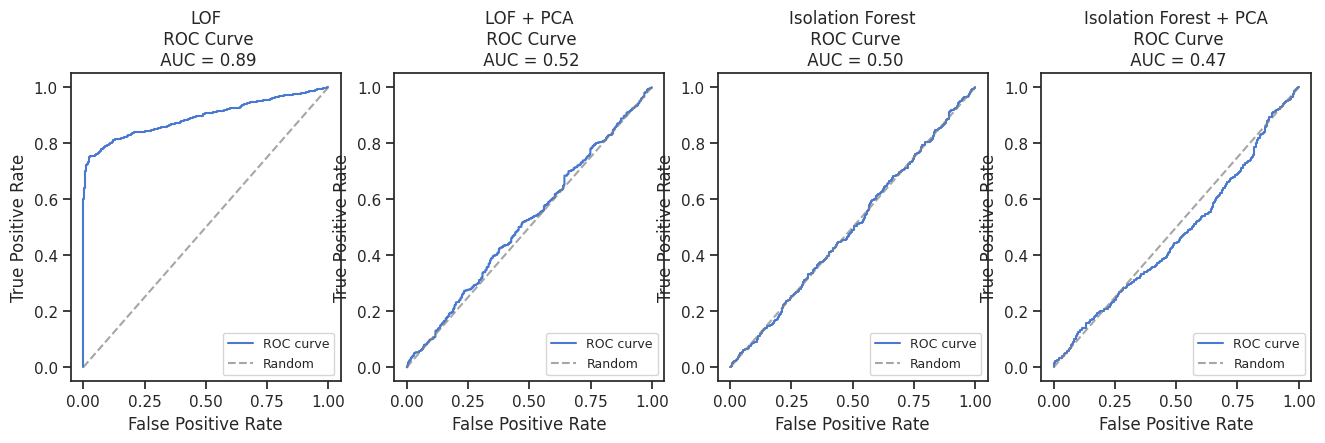

In [59]:
valve_allF_means = classify_anomalies(train_data[valcols], test_data[valcols], y_val, 'valve', 'All-means')
print(valve_allF_means.to_markdown())

## Fan

In [60]:
df_valve =  pd.read_pickle('working/df_valve_means.pkl')
df_fan =  pd.read_pickle('working/df_fan_means.pkl')

In [61]:
norm = df_fan[(df_fan["label"] == 1)].sample(frac = 0.8, random_state = 66)
df_fan['train'] = 0
df_fan['test'] = 0
df_fan.loc[norm.index, 'train'] = 1
df_fan.loc[df_fan.index, 'test'] = 1

In [62]:
train_data = df_fan[df_fan['train'] == 1]
test_data = df_fan[df_fan['test'] == 1]
y_val = df_fan[(df_fan["test"] == 1)]['label'].tolist()

In [63]:
fancols = df_fan.columns[8:]
chroma_only = [col for col in fancols if col.startswith('chroma')]
mel_only = [col for col in fancols if col.startswith('mf') or col.startswith('lm')]

mel-means features were reduced to 14 components for LOF
mel-means features were reduced to 14 components for Isolation Forest
|    | Machine   | Features   | Model                  |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
|---:|:----------|:-----------|:-----------------------|---------:|---------:|------------:|-------------------:|
|  0 | fan       | mel-means  | LOF                    | 0.771191 | 0.528989 |    0.770423 |           0.507762 |
|  1 | fan       | mel-means  | LOF + PCA              | 0.754992 | 0.493771 |    0.761405 |           0.490966 |
|  2 | fan       | mel-means  | Isolation Forest       | 0.576209 | 0.415189 |    0.698318 |           0.443837 |
|  3 | fan       | mel-means  | Isolation Forest + PCA | 0.546494 | 0.401533 |    0.671401 |           0.430201 |


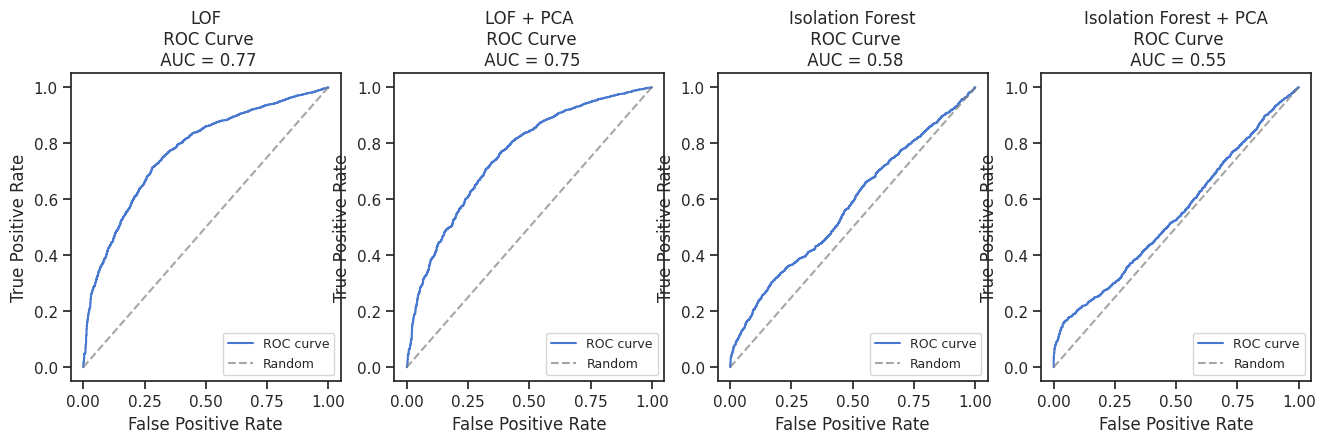

In [64]:
fan_mel_means = classify_anomalies(train_data[mel_only], test_data[mel_only], y_val, 'fan', 'mel-means')
print(fan_mel_means.to_markdown())

chroma-means features were reduced to 8 components for LOF
chroma-means features were reduced to 8 components for Isolation Forest
|    | Machine   | Features     | Model                  |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
|---:|:----------|:-------------|:-----------------------|---------:|---------:|------------:|-------------------:|
|  0 | fan       | chroma-means | LOF                    | 0.680485 | 0.431481 |    0.718681 |           0.455359 |
|  1 | fan       | chroma-means | LOF + PCA              | 0.689672 | 0.434835 |    0.720458 |           0.456827 |
|  2 | fan       | chroma-means | Isolation Forest       | 0.575532 | 0.370867 |    0.660607 |           0.424375 |
|  3 | fan       | chroma-means | Isolation Forest + PCA | 0.608773 | 0.385242 |    0.680847 |           0.433053 |


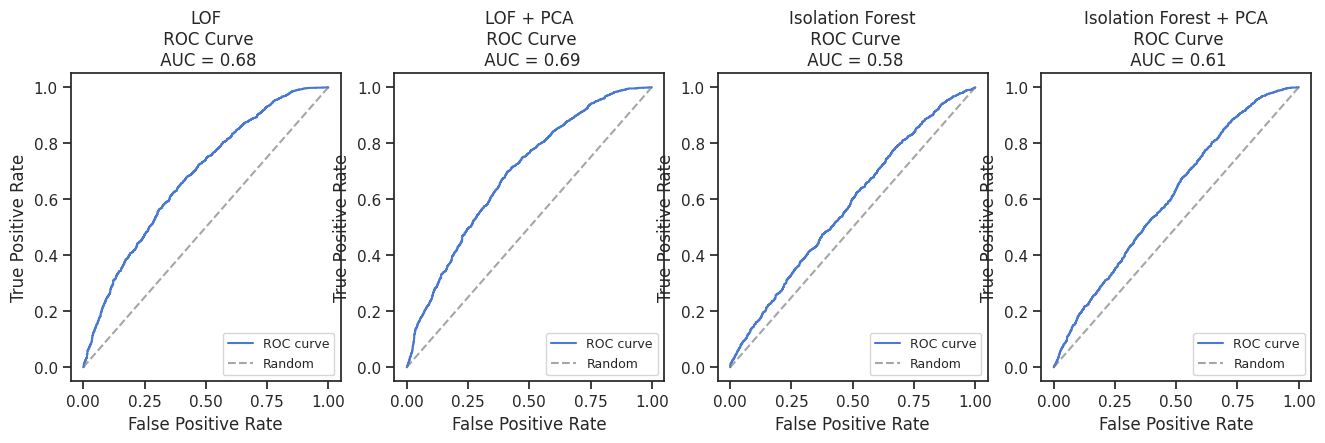

In [65]:
fan_chroma_means = classify_anomalies(train_data[chroma_only], test_data[chroma_only], y_val, 'fan', 'chroma-means')
print(fan_chroma_means.to_markdown())

In [66]:
# fancols = df_fan.drop('recording', axis=1).columns[8:]
fancols = df_fan.columns[8:]

# 문자열 값 필터링 (normal 제거)
train_data = train_data[train_data[fancols[0]] != 'normal']  # fancols[0]은 fancols의 첫 번째 열을 가정
test_data = test_data[test_data[fancols[0]] != 'normal']

All-means features were reduced to 18 components for LOF
All-means features were reduced to 18 components for Isolation Forest
|    | Machine   | Features   | Model                  |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
|---:|:----------|:-----------|:-----------------------|---------:|---------:|------------:|-------------------:|
|  0 | fan       | All-means  | LOF                    | 0.906268 | 0.824389 |    0.87603  |           0.740531 |
|  1 | fan       | All-means  | LOF + PCA              | 0.789955 | 0.536895 |    0.777443 |           0.5142   |
|  2 | fan       | All-means  | Isolation Forest       | 0.579546 | 0.42597  |    0.703139 |           0.447672 |
|  3 | fan       | All-means  | Isolation Forest + PCA | 0.568403 | 0.394346 |    0.677923 |           0.432675 |


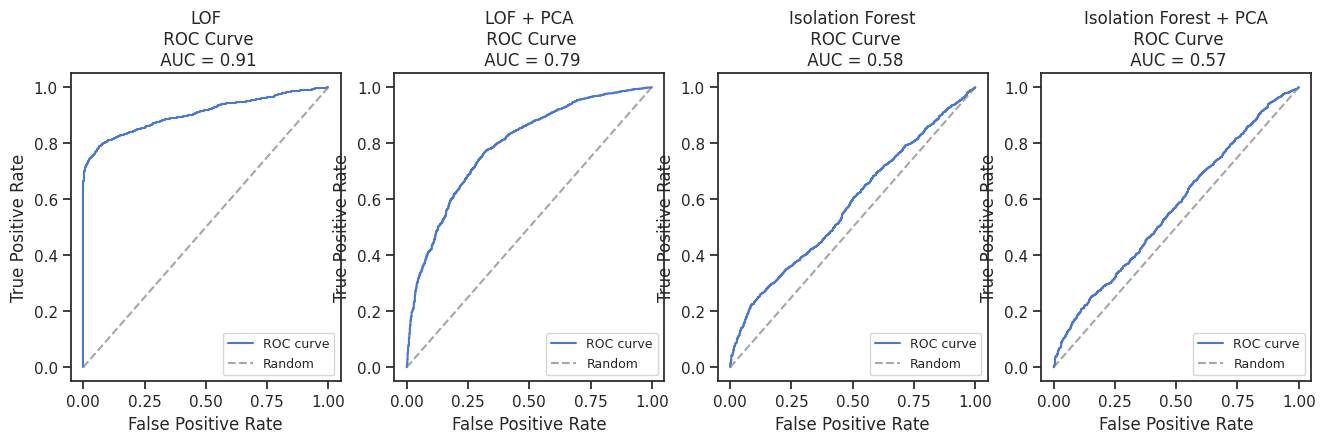

In [67]:
fan_allF_means = classify_anomalies(train_data[fancols], test_data[fancols], y_val, 'fan', 'All-means')
print(fan_allF_means.to_markdown())

# Mean vs no mean
***

In [68]:
fan_res = pd.concat([fan_allF_means, fan_chroma_means, fan_mel_means, fan_allF, fan_chroma, fan_mel], ignore_index=True).sort_values('Abnormal (-1) F1', ascending=False)
valve_res = pd.concat([valve_allF_means, valve_chroma_means, valve_mel_means, valve_allF, valve_chroma, valve_mel], ignore_index=True).sort_values('Abnormal (-1) F1', ascending=False)

In [69]:
print('Valve machine sound classification - means v no means -  Sorted by best F1 score of the abnormal class -1')
print(valve_res.head().to_markdown())

Valve machine sound classification - means v no means -  Sorted by best F1 score of the abnormal class -1
|    | Machine   | Features     | Model                  |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
|---:|:----------|:-------------|:-----------------------|---------:|---------:|------------:|-------------------:|
|  0 | valve     | All-means    | LOF                    | 0.893442 | 0.799215 |    0.912999 |           0.518053 |
|  4 | valve     | chroma-means | LOF                    | 0.509474 | 0.242315 |    0.805129 |           0.210562 |
| 11 | valve     | mel-means    | Isolation Forest + PCA | 0.496053 | 0.241988 |    0.803451 |           0.209952 |
|  3 | valve     | All-means    | Isolation Forest + PCA | 0.472999 | 0.241661 |    0.803252 |           0.209881 |
| 22 | valve     | mel          | Isolation Forest       | 0.489553 | 0.24068  |    0.799705 |           0.208589 |


In [70]:
print('Fan machine sound classification - means v no means - Sorted by best F1 score of the abnormal class -1')
print(fan_res.head().to_markdown())

Fan machine sound classification - means v no means - Sorted by best F1 score of the abnormal class -1
|    | Machine   | Features   | Model     |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
|---:|:----------|:-----------|:----------|---------:|---------:|------------:|-------------------:|
|  0 | fan       | All-means  | LOF       | 0.906268 | 0.824389 |    0.87603  |           0.740531 |
|  1 | fan       | All-means  | LOF + PCA | 0.789955 | 0.536895 |    0.777443 |           0.5142   |
|  8 | fan       | mel-means  | LOF       | 0.771191 | 0.528989 |    0.770423 |           0.507762 |
|  9 | fan       | mel-means  | LOF + PCA | 0.754992 | 0.493771 |    0.761405 |           0.490966 |
| 12 | fan       | All        | LOF       | 0.703695 | 0.493771 |    0.748859 |           0.485262 |


***
# Compile All Results 
#### - incl. AE from 1-AutoEncoder_Comp.ipynb

In [71]:
AE_fan_res = pd.read_pickle('working/AE_fan_res.pkl')
AE_valve_res = pd.read_pickle('working/AE_valve_res.pkl')

In [72]:
fan_all = pd.concat([AE_fan_res, fan_res.iloc[0:5]], ignore_index=True).sort_values('Abnormal (-1) F1', ascending=False)
valve_all = pd.concat([AE_valve_res, valve_res.iloc[0:5]], ignore_index=True).sort_values('Abnormal (-1) F1', ascending=False)

In [73]:
fan_all.columns = fan_all.columns.str.strip()
valve_all.columns = valve_all.columns.str.strip()

In [74]:
print('Valve machine sound classification - All models and Feature combos -  Sorted by best F1 score of the abnormal class -1')
print(valve_all.to_markdown(tablefmt="grid"))

Valve machine sound classification - All models and Feature combos -  Sorted by best F1 score of the abnormal class -1
+----+------------------------+-----------+--------------+----------+-------------+----------+--------------------+
|    | Model                  | Machine   | Features     |      AUC |   Precision |   Recall |   Abnormal (-1) F1 |
+====+========================+===========+==============+==========+=============+==========+====================+
|  2 | LOF                    | valve     | All-means    | 0.893442 |    0.912999 | 0.799215 |          0.518053  |
+----+------------------------+-----------+--------------+----------+-------------+----------+--------------------+
|  3 | LOF                    | valve     | chroma-means | 0.509474 |    0.805129 | 0.242315 |          0.210562  |
+----+------------------------+-----------+--------------+----------+-------------+----------+--------------------+
|  4 | Isolation Forest + PCA | valve     | mel-means    | 0.496053 |

In [75]:
print('Fan machine sound Anomaly detection - All models and Feature combos - Sorted by best F1 score of the abnormal class -1')
print(fan_all.to_markdown(tablefmt="grid"))

Fan machine sound Anomaly detection - All models and Feature combos - Sorted by best F1 score of the abnormal class -1
+----+-----------+-----------+------------+----------+-------------+----------+--------------------+
|    | Model     | Machine   | Features   |      AUC |   Precision |   Recall |   Abnormal (-1) F1 |
+====+===========+===========+============+==========+=============+==========+====================+
|  2 | LOF       | fan       | All-means  | 0.906268 |    0.87603  | 0.824389 |           0.740531 |
+----+-----------+-----------+------------+----------+-------------+----------+--------------------+
|  3 | LOF + PCA | fan       | All-means  | 0.789955 |    0.777443 | 0.536895 |           0.5142   |
+----+-----------+-----------+------------+----------+-------------+----------+--------------------+
|  4 | LOF       | fan       | mel-means  | 0.771191 |    0.770423 | 0.528989 |           0.507762 |
+----+-----------+-----------+------------+----------+-------------+-----